In [4]:
import torch
import pandas as pd
import os
import cv2
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
import sklearn
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from torchvision.transforms import v2
from PIL import Image
import pandas as pd
import os
import numpy as np
from tqdm import tqdm


device = torch.device(torch.accelerator.current_accelerator() if torch.accelerator.is_available() else 'cpu')

device

device(type='cuda')

In [5]:
print(torch.version.cuda)
print(torch.backends.cudnn.version())

11.8
90100


In [6]:
# === CONFIG ===
input_dir = r"C:airbus-ship-detection\train_v2"
output_dir = r"C:airbus-ship-detection\train_v2_resized"
target_size = (256, 256)

# === Check if resizing is needed ===
if not os.path.exists(output_dir) or len(os.listdir(output_dir)) == 0:
    print("Resizing images to 256x256...")

    os.makedirs(output_dir, exist_ok=True)
    image_files = [f for f in os.listdir(input_dir) if f.endswith(".jpg")]

    for fname in tqdm(image_files, desc="Resizing"):
        try:
            img = Image.open(os.path.join(input_dir, fname)).convert("RGB")
            img_resized = img.resize(target_size, Image.BILINEAR)
            img_resized.save(os.path.join(output_dir, fname))
        except Exception as e:
            print(f"Failed to resize {fname}: {e}")
else:
    print("Resized image directory is already po" \
    "pulated — skipping resize.")


Resized image directory is already populated — skipping resize.


In [15]:
# === CONFIGURATION ===
csv_path = r"C:airbus-ship-detection\train_ship_segmentations_v2.csv"
mask_output_dir = r"C:airbus-ship-detection\train_masks"
target_size = (768, 768)
os.makedirs(mask_output_dir, exist_ok=True)

# === RLE Decode Function ===
def rle_decode(mask_rle, shape=(768, 768)):
    s = list(map(int, mask_rle.split()))
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

if os.path.exists(mask_output_dir) and len(os.listdir(output_dir)) != 0:

    # === Load CSV and group RLEs by ImageId ===
    df = pd.read_csv(csv_path)
    df['HasShip'] = df['EncodedPixels'].notnull()
    grouped = df.groupby('ImageId')['EncodedPixels'].apply(list)

    # === Process Each Image ===
    for image_id, rles in tqdm(grouped.items(), desc="Generating masks"):
        out_path = os.path.join(mask_output_dir, image_id.replace(".jpg", ".png"))

        if os.path.exists(out_path):
            continue  # skip if already processed

        # Combine all masks (if any)
        mask = np.zeros((768, 768), dtype=np.uint8)
        for rle in rles:
            if isinstance(rle, str):
                mask += rle_decode(rle)
        mask = np.clip(mask, 0, 1) * 255  # binary to uint8 image

        # Resize mask to 256×256
        mask_img = Image.fromarray(mask.astype(np.uint8))
        mask_img = mask_img.resize(target_size, resample=Image.NEAREST)
        mask_img.save(out_path)
else:
    print("Masks are already generated and saved in the specified directory.")

Generating masks: 192556it [09:03, 354.47it/s]


In [8]:
'''#check if the resized images are of the correct size
def check_image_sizes(directory, target_size=(256, 256)):
    for fname in os.listdir(directory):
        if fname.endswith(".jpg"):
            img_path = os.path.join(directory, fname)
            img = Image.open(img_path)
            if img.size != target_size:
                print(f"Image {fname} is not of size {target_size}. Found size: {img.size}")
            else:
                print(f"Image {fname} is of correct size: {img.size}")

check_image_sizes(output_dir, target_size)'''

'#check if the resized images are of the correct size\ndef check_image_sizes(directory, target_size=(256, 256)):\n    for fname in os.listdir(directory):\n        if fname.endswith(".jpg"):\n            img_path = os.path.join(directory, fname)\n            img = Image.open(img_path)\n            if img.size != target_size:\n                print(f"Image {fname} is not of size {target_size}. Found size: {img.size}")\n            else:\n                print(f"Image {fname} is of correct size: {img.size}")\n\ncheck_image_sizes(output_dir, target_size)'

In [9]:
import pandas as pd


df = pd.read_csv("airbus-ship-detection/train_ship_segmentations_v2.csv")

# Ship column
df['HasShip'] = df['EncodedPixels'].notnull()

# Ship count per image
ship_counts = df.groupby('ImageId')['HasShip'].sum().reset_index()
ship_counts.columns = ['ImageId', 'ShipCount']

# Step 4: Count how many images have 0, 1, 2, 3, ... ships
ship_distribution = ship_counts['ShipCount'].value_counts().sort_index()

# Optional: Display the result
print("Ship Count Distribution (Number of ships per image):")
for ship_num, image_count in ship_distribution.items():
    print(f"{int(ship_num)} ships: {image_count} images")

# Percentage of images with ships unique
ship_counts['HasShip'] = ship_counts['ShipCount'] > 0
percentage_with_ships = ship_counts['HasShip'].mean() * 100
print(f"Percentage of images with ships: {percentage_with_ships:.2f}%")

df

Ship Count Distribution (Number of ships per image):
0 ships: 150000 images
1 ships: 27104 images
2 ships: 7674 images
3 ships: 2954 images
4 ships: 1622 images
5 ships: 925 images
6 ships: 657 images
7 ships: 406 images
8 ships: 318 images
9 ships: 243 images
10 ships: 168 images
11 ships: 144 images
12 ships: 124 images
13 ships: 75 images
14 ships: 76 images
15 ships: 66 images
Percentage of images with ships: 22.10%


,ImageId,EncodedPixels,HasShip
0,00003e153.jpg,NaN,False
1,0001124c7.jpg,NaN,False
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,True
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,True
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,True
...,...,...,...
231718,fffedbb6b.jpg,NaN,False
231719,ffff2aa57.jpg,NaN,False
231720,ffff6e525.jpg,NaN,False
231721,ffffc50b4.jpg,NaN,False


In [10]:
import numpy as np

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    Converts RLE string to binary mask (numpy 2D array).
    '''
    if pd.isnull(mask_rle):
        return np.zeros(shape, dtype=np.uint8)

    s = list(map(int, mask_rle.split()))
    starts, lengths = s[::2], s[1::2]

    starts = np.array(starts) - 1  # switch to 0-based indexing
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)

    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1

    return img.reshape((shape[1], shape[0])).T  # reshape & transpose for (H, W)

def get_combined_mask(image_id, df, shape=(768, 768)):
    """
    Returns a binary mask for an image with possibly multiple ships.
    - image_id: name of the image (e.g., '00003e153.jpg')
    - df: the full DataFrame from the CSV
    - shape: expected shape of the output mask (default 768x768)
    """
    # Get all RLEs for the image
    rles = df[df["ImageId"] == image_id]["EncodedPixels"].dropna().values
    
    # Start with empty mask
    final_mask = np.zeros(shape, dtype=np.uint8)
    
    for rle in rles:
        final_mask += rle_decode(rle, shape=shape)
    
    # Make sure the mask is binary (in case ships overlap)
    final_mask = np.clip(final_mask, 0, 1)
    
    return final_mask

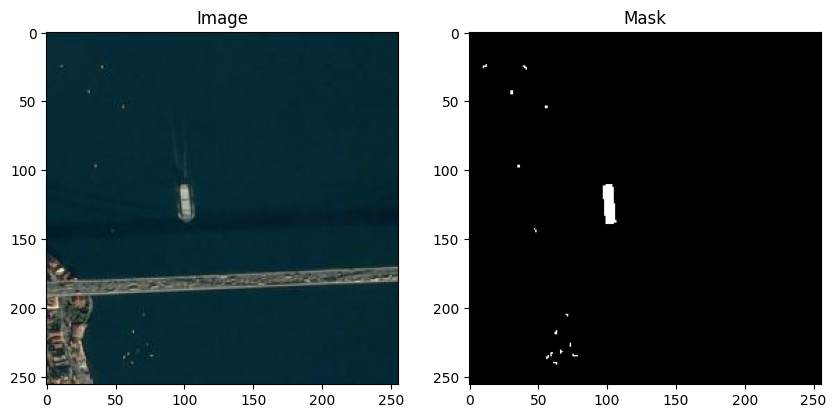

In [11]:
# show the image ./airbus-ship-detection/train_v2/000194a2d.jpg
import matplotlib.pyplot as plt
from PIL import Image

def show_image_with_mask(image_id, df, shape=(768, 768)):
    """
    Displays the image and its corresponding mask.
    - image_id: name of the image (e.g., '00003e153.jpg')
    - df: the full DataFrame from the CSV
    - shape: expected shape of the mask (default 768x768)
    """
    # Load the image
    img_path = os.path.join("./airbus-ship-detection/train_v2_resized", image_id)
    img = Image.open(img_path).convert("RGB")
    
    # Load the mask image (as .png)
    mask_path = os.path.join("./airbus-ship-detection/train_masks_resized", image_id.replace('.jpg', '.png'))
    mask = Image.open(mask_path)
    
    # Display the image and mask
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    
    plt.show()

# Example usage
show_image_with_mask('ad5092ca2.jpg', df)

# Datasets

In [10]:
class ShipDataset(Dataset):
    def __init__(self, dataframe, image_folder, device='cpu'):
        self.df = dataframe
        self.image_folder = image_folder
        self.device = device

        # Unique image names and RLE groupings
        self.image_ids = self.df['ImageId'].unique()
        self.masks = self.df.groupby('ImageId')['EncodedPixels'].apply(list)

        # Minimal preprocessing
        self.image_transform = v2.Compose([
            v2.Resize((256, 256)),
            v2.ToImage(),               # Converts PIL/numpy to torch.Tensor
            v2.ToDtype(torch.float32, scale=True),  # Scales image to [0,1]
            v2.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
        ]).to(self.device)

        self.mask_transform = v2.Compose([
            v2.Resize((256, 256)),
            v2.ToImage(),               # Converts PIL/numpy to torch.Tensor
            v2.ToDtype(torch.float32, scale=True)  # Scales image to [0,1]
        ]).to(self.device)

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_folder, image_id)
        mask_path = os.path.join("./airbus-ship-detection/train_masks_resized", image_id.replace('.jpg', '.png'))

        # Load image
        image = Image.open(image_path).convert('RGB')

        # Load mask
        if os.path.exists(mask_path):
            mask = Image.open(mask_path).convert('L')
        else:
            # If mask doesn't exist, create an empty mask
            mask = Image.new('L', (768, 768), 0)
        
        # Apply transforms
        image = self.image_transform(image)
        mask = self.mask_transform(mask)

        return image, mask


In [11]:
# Get all ship image IDs
ship_ids = df[df['HasShip']]['ImageId'].drop_duplicates()
print(len(ship_ids))

train_df = df[df['ImageId'].isin(ship_ids)].sample(10000, random_state=42).reset_index(drop=True)

42556


Shapes:  torch.Size([3, 256, 256]) torch.Size([1, 256, 256])


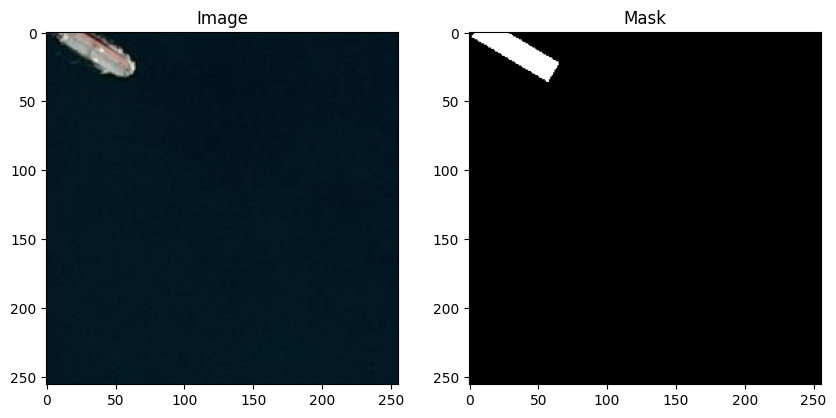

In [12]:
# train val split
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

train_dataset = ShipDataset(train_df, "./airbus-ship-detection/train_v2_resized")
image, mask = train_dataset[0]
print("Shapes: ", image.shape, mask.shape)

show_image_with_mask(train_df['ImageId'].iloc[90], df)
val_dataset = ShipDataset(val_df, "./airbus-ship-detection/train_v2_resized")

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class BetterSegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.enc1 = ConvBlock(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = ConvBlock(256, 512)

        # Decoder
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = ConvBlock(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = ConvBlock(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = ConvBlock(128, 64)

        # Output layer
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool1(x1))
        x3 = self.enc3(self.pool2(x2))

        # Bottleneck
        x4 = self.bottleneck(self.pool3(x3))

        # Decoder with skip connections
        x = self.up3(x4)
        x = self.dec3(torch.cat([x, x3], dim=1))
        x = self.up2(x)
        x = self.dec2(torch.cat([x, x2], dim=1))
        x = self.up1(x)
        x = self.dec1(torch.cat([x, x1], dim=1))

        # Output
        return self.final(x)  # raw logits


model = BetterSegNet().to(device)

In [16]:
def dice_score(preds, targets, threshold=0.5, epsilon=1e-6):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = preds.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3))
    dice = (2. * intersection + epsilon) / (union + epsilon)
    return dice.mean().item()


In [ ]:
def dice_loss(pred, target, smooth=1):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def focal_loss(pred, target, alpha=0.8, gamma=2):
    pred = torch.sigmoid(pred)
    bce = F.binary_cross_entropy(pred, target, reduction='none')
    pt = torch.exp(-bce)
    return (alpha * (1 - pt) ** gamma * bce).mean()

def combined_loss(pred, target):
    return 0.5 * dice_loss(pred, target) + 0.5 * focal_loss(pred, target)


In [ ]:
def train_model(model, train_loader, val_loader, device, epochs=10, lr=1e-3, weight_decay=1e-4):
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss, train_dice = 0.0, 0.0

        loop = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")
        for images, masks in loop:
            images, masks = images.to(device), masks.to(device)
            preds = model(images)  # keep shape [batch, 1, 256, 256]

            loss = combined_loss(preds, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_dice += dice_score(preds, masks)

        # Validation
        model.eval()
        val_loss, val_dice = 0.0, 0.0
        with torch.no_grad():
            for images, masks in val_dataloader:
                images, masks = images.to(device), masks.to(device)
                preds = model(images)  # keep shape [batch, 1, 256, 256]
                val_loss += combined_loss(preds, masks).item()
                val_dice += dice_score(preds, masks)

        print(f"Epoch {epoch:02} | "
              f"Train Loss: {train_loss/len(train_loader):.4f}, Dice: {train_dice/len(train_loader):.4f} | "
              f"Val Loss: {val_loss/len(val_loader):.4f}, Dice: {val_dice/len(val_loader):.4f}")

train_model(model, train_dataloader, val_dataloader, device, epochs=10, lr=1e-3, weight_decay=1e-4)

Epoch 1/10: 100%|██████████| 1777/1777 [04:26<00:00,  6.66it/s]


Epoch 01 | Train Loss: 0.0338, Dice: 0.1669 | Val Loss: 0.0179, Dice: 0.1912


Epoch 2/10: 100%|██████████| 1777/1777 [04:34<00:00,  6.46it/s]


Epoch 02 | Train Loss: 0.0162, Dice: 0.2948 | Val Loss: 0.0200, Dice: 0.3375


Epoch 3/10: 100%|██████████| 1777/1777 [04:40<00:00,  6.34it/s]


Epoch 03 | Train Loss: 0.0148, Dice: 0.3333 | Val Loss: 0.0166, Dice: 0.0509


Epoch 4/10: 100%|██████████| 1777/1777 [04:38<00:00,  6.39it/s]


Epoch 04 | Train Loss: 0.0140, Dice: 0.3682 | Val Loss: 0.0158, Dice: 0.2052


Epoch 5/10: 100%|██████████| 1777/1777 [04:25<00:00,  6.69it/s]


Epoch 05 | Train Loss: 0.0131, Dice: 0.3942 | Val Loss: 0.0137, Dice: 0.3853


Epoch 6/10: 100%|██████████| 1777/1777 [04:35<00:00,  6.45it/s]


Epoch 06 | Train Loss: 0.0124, Dice: 0.4168 | Val Loss: 0.0139, Dice: 0.3709


Epoch 7/10: 100%|██████████| 1777/1777 [04:30<00:00,  6.56it/s]


Epoch 07 | Train Loss: 0.0119, Dice: 0.4345 | Val Loss: 0.0139, Dice: 0.3903


Epoch 8/10: 100%|██████████| 1777/1777 [04:27<00:00,  6.64it/s]


Epoch 08 | Train Loss: 0.0112, Dice: 0.4572 | Val Loss: 0.0122, Dice: 0.3047


Epoch 9/10: 100%|██████████| 1777/1777 [04:29<00:00,  6.59it/s]


Epoch 09 | Train Loss: 0.0105, Dice: 0.4687 | Val Loss: 0.0113, Dice: 0.3937


Epoch 10/10:  32%|███▏      | 560/1777 [01:26<03:08,  6.47it/s]


KeyboardInterrupt: 

In [14]:
import time

model.eval()
x = torch.randn(1, 3, 256, 256).to(device)

start = time.time()
with torch.no_grad():
    y = model(x)
end = time.time()

print(f"Inference time for 1 image: {end - start:.4f} seconds")


Inference time for 1 image: 0.4388 seconds
